# Big Data in Geographic Information Systems - Project

Part 1 (notebook 1.ipynb):

- Perform hypothesis tests on the linear trends of gridded precipitation observational data implementing the False Discovery Rate (FDR) approach described in Wilks (2016), using the same data in order to validate the correctness of the implementation.

Part 2 (notebook 2.ipynb):

- Apply the FDR approach to temperature data from CMIP6 climate models to test the significance of temperature trends.

## References

1. Wilks, D. S., 2016: "The Stippling Shows Statistically Significant Grid Points": How Research Results are Routinely Overstated and Overinterpreted, and What to Do about It. Bull. Amer. Meteor. Soc., 97, 2263–2273, https://doi.org/10.1175/BAMS-D-15-00267.1.
2. Hartmann, D.L., A.M.G. Klein Tank, M. Rusticucci, L. Alexander, S. Brönnimann, Y. Charabi, F. Dentener, E. Dlugo-kencky, D. Easterling, A. Kaplan, B. Soden, P. Thorne, M. Wild and P.M. Zhai, 2013: Observations: Atmosphere and Surface Supplementary Material. In: Climate Change 2013: The Physical Science Basis. Contribution of Working Group I to the Fifth Assessment Report of the Intergovernmental Panel on Climate Change [Stocker, T.F., D. Qin, G.-K. Plattner, M. Tignor, S.K. Allen, J. Boschung, A. Nauels, Y. Xia, V. Bex and P.M. Midgley (eds.)]. Available from www.climatechange2013.org and www.ipcc.ch.

## Part 1 - Precipitation trends 1951-2010 - Observational data

The goal of the first part of this project is to use gridded precipitation observational data from the Global Historical Climatology Network to estimate the linear trend of precipitations in each grid cell (with available data) from 1951-2010.

An hypothesis test is performed on the trend of the precipitations in each cell to ensure its statistical significance. To this end, the *False Discovery Rate* (FDR) approach described in Wilks (2016) is followed for the correct interpretation of the results of multiple statistical hypothesis tests. The precipitation data is the same of Wilks (2016), so that the correctness of our implementation of the FDR approach can be validated.

## Import Libraries

In [1]:
import os

import numpy as np
import xarray as xr

import pandas as pd

import datetime as dtm
from datetime import datetime

import cartopy.crs as ccrs

from tqdm.notebook import tqdm

Import some matplotlib functions and the function `make_colormap` form `utils.py` which is useful to create a colormap (found [here](https://stackoverflow.com/questions/16834861/create-own-colormap-using-matplotlib-and-plot-color-scale)).

In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from matplotlib.lines import Line2D
from utils import make_colormap
to_rgb = colors.ColorConverter().to_rgb

### Import Data

The gridded precipitation data comes from the Global Historical Climatology Network:

- Description: https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/global-historical-climatology-network-monthly-version-2
- Gridded data source: ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/v2/grid/

In [3]:
data_fn = "./data/grid_prcp_1900-current.dat"

The file is small enough to be loaded in memory:

In [4]:
with open(data_fn, 'r') as fn:
    content = fn.readlines()

In [5]:
for i in range(5):
    print(content[i])

    1 1900

 -32768 -32768 -32768 -32768 -32768 -32768 -32768 -32768 -32768 -32768 -32768 -32768

 -32768 -32768 -32768 -32768 -32768 -32768 -32768 -32768 -32768 -32768 -32768 -32768

 -32768 -32768 -32768 -32768 -32768 -32768 -32768 -32768 -32768 -32768 -32768 -32768

 -32768 -32768 -32768 -32768 -32768 -32768 -32768 -32768 -32768 -32768 -32768 -32768



There are two kinds of lines in the data:

- Lines containing a month and a year
- Lines containing precipitation data. These are organized as follows (from the dataset README):
    - there are twelve longitude grid values per line, so there are 6 lines (72/12 = 6) for each of the 36 latitude bands.
    - Longitude values are written from 180 W to 180 E,
    - Latitude values are written from 90 N to 90 S.

The dataset README also specifies that precipitation data are provided as anomalies (computed with respect to the period 1961-1990) in hundreths of a millimiter, and that each gridded value was multiplied by 100 and written to file as an integer. Thus, the unit of measurement of the precipitation anomalies is millimiters.

The lines containing the months and year have length 11, the others have length 85.

In [6]:
np.unique([len(f) for f in content])

array([11, 85])

The data goes from 1900 to 2015:

In [7]:
dates = np.array([el.split() for el in content if len(el) == 11])
dates[0], dates[-1]

(array(['1', '1900'], dtype='<U4'), array(['12', '2015'], dtype='<U4'))

Let us create a datetime range for convenience:

In [8]:
time = pd.date_range(start = "1900", end = "2016", freq = "M")
time

DatetimeIndex(['1900-01-31', '1900-02-28', '1900-03-31', '1900-04-30',
               '1900-05-31', '1900-06-30', '1900-07-31', '1900-08-31',
               '1900-09-30', '1900-10-31',
               ...
               '2015-03-31', '2015-04-30', '2015-05-31', '2015-06-30',
               '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-31',
               '2015-11-30', '2015-12-31'],
              dtype='datetime64[ns]', length=1392, freq='M')

### Data Grid

We now create a grid containing the precipitation data.

We start by discarding the lines containing the month and year (so we keep only the lines of length 85, which are the ones containing the precipitation data) and creating a numpy array:

In [9]:
data = np.array([el.split() for el in content if len(el) == 85], dtype = float) # float because we need np.nan

Missing values are represented by the value -32768 (from the dataset README).

In [10]:
data[data == -32768] = np.nan

The grid cells have size $5\times 5$ degrees, so the grid will consist of an array of shape (180/5, 360/5) for each timestep:

In [11]:
nlat = 180//5
nlon = 360//5

We have 116 years of data:

In [12]:
nyrs = 116
nmons = nyrs*12
nmons

1392

At this point the data has the following shape:

In [13]:
data.shape

(300672, 12)

We need to reshape it to (nmons, nlat, nlon):

Let us test the numpy `flatten` and `reshape` functions to understand how to apply it to the precipitation data in order to correctly obtain the desired shape.

In [14]:
a = np.arange(36).reshape(3, 12)
print(a)

[[ 0  1  2  3  4  5  6  7  8  9 10 11]
 [12 13 14 15 16 17 18 19 20 21 22 23]
 [24 25 26 27 28 29 30 31 32 33 34 35]]


In [15]:
b = a.flatten()
print(b)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35]


In [16]:
c = b.reshape(3, 3, 4)
print(c)

[[[ 0  1  2  3]
  [ 4  5  6  7]
  [ 8  9 10 11]]

 [[12 13 14 15]
  [16 17 18 19]
  [20 21 22 23]]

 [[24 25 26 27]
  [28 29 30 31]
  [32 33 34 35]]]


The following line reshapes the data as the desired grid:

In [17]:
grid = np.reshape(data.flatten(), (nmons, nlat, nlon))

Let us plot the precipitation anomalies for a single cell:

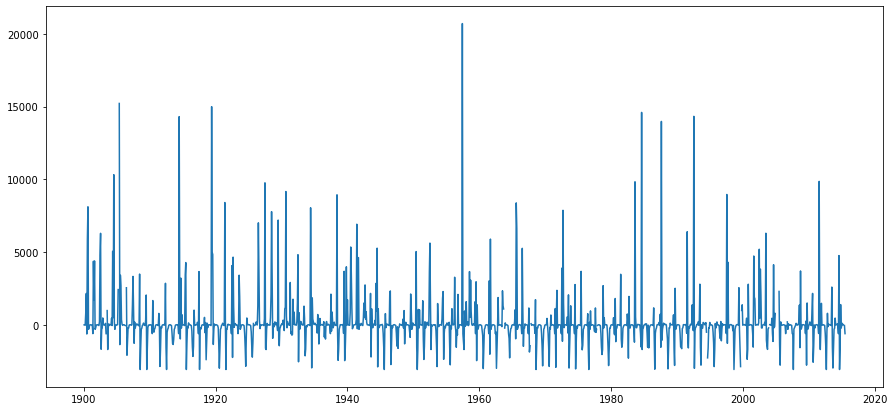

In [18]:
plt.figure(figsize=(15, 7))
plt.plot(time, grid[:, 23,21])
plt.show()

### Data Xarray

Let us store the grid using xarray so that we can index it by time, latitude and longitude. For latitudes and longitudes we use the center of each $5\times 5$ cell.

In [19]:
resol = 5
xlons =  np.arange(-177.5, 180, resol, dtype=float)
xlats =  -np.arange(-87.5, 90, resol, dtype=float)

In [20]:
xgrid = xr.DataArray(grid, coords=[time, xlats, xlons], dims=["time", "lat", "lon"])

In [21]:
xgrid.coords

Coordinates:
  * time     (time) datetime64[ns] 1900-01-31 1900-02-28 ... 2015-12-31
  * lat      (lat) float64 87.5 82.5 77.5 72.5 67.5 ... -72.5 -77.5 -82.5 -87.5
  * lon      (lon) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5

Let us plot the same cell as above:

In [22]:
xlats[23], xlons[21]

(-27.5, -72.5)

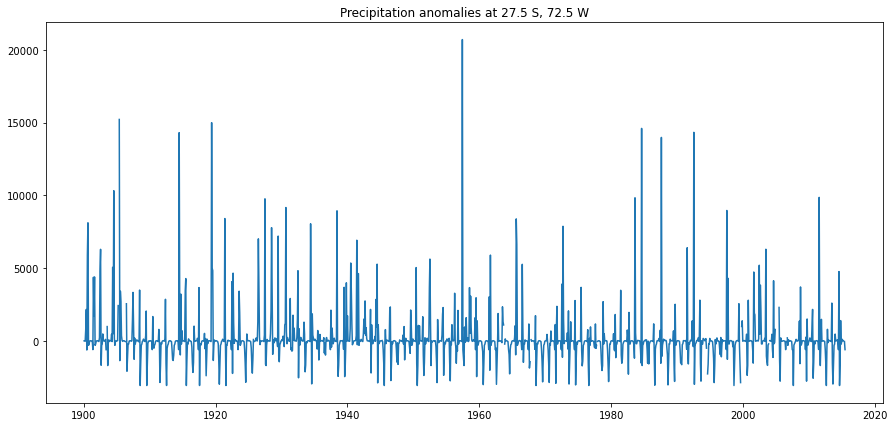

In [23]:
plt.figure(figsize=(15, 7))
plt.title("Precipitation anomalies at 27.5 S, 72.5 W")
plt.plot(time, xgrid.sel(lat=-27.5, lon=-72.5))
plt.show()

We can specify `method = "nearest"` so that xarray chooses the nearest grid cell center:

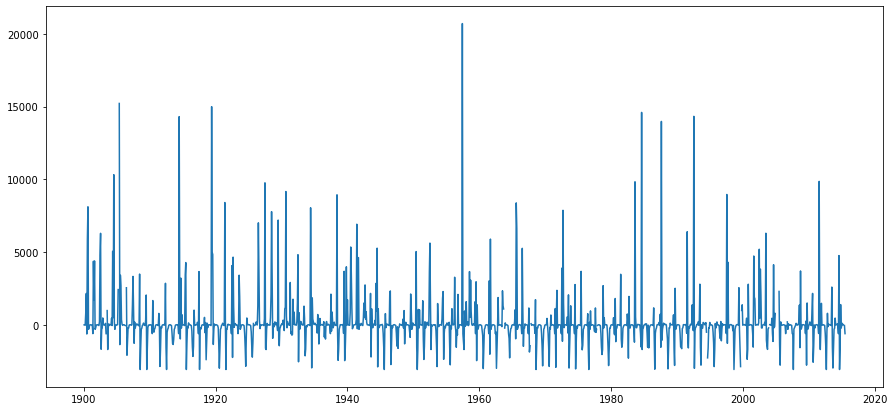

In [24]:
plt.figure(figsize=(15, 7))
plt.plot(time, xgrid.sel(lat=-30, lon=-75, method="nearest"))
plt.show()

Let us save the 1951-2010 date range in a variable:

In [25]:
timeslice = xgrid.sel(time=slice("1951", "2010")).time

Same cell, from 1951 to 2010:

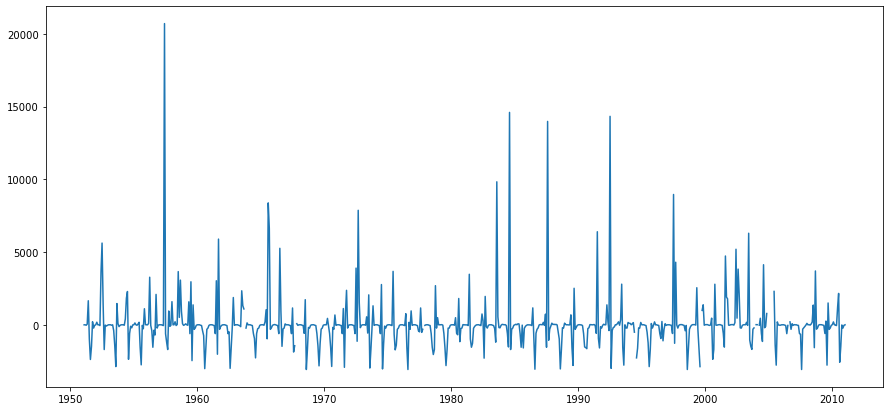

In [26]:
plt.figure(figsize=(15, 7))
plt.plot(timeslice, xgrid.sel(time = timeslice).sel(lat=-30, lon=-75, method="nearest"))
plt.show()

### Validate Data

Following Wilks (2016), we are going to estimate the precipitation trends from 1951 to 2010, considering only grid cells that satisfy the following criteria:

- The grid has at least 42 (70%) complete years.
- At least two complete years in 1951-1956.
- At least two complete years in 2005-2010.

These criteria will be verified as the following example shows.

Select the 1951-2010 data from some cell:

In [27]:
test = xgrid.sel(time=timeslice)[:, 23, 21]

We locate the available monthly observations and reshape the array so that each row corresponds to one year (we only print the first three rows here, i.e., the first three years).

In [28]:
avail_months = ~np.isnan(np.array(test)).reshape(60, 12) # 60 is the number of years between 1951-2010
print(avail_months[:3, :]) # First three years

[[ True  True  True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True]
 [ True  True  True  True  True  True  True  True  True  True  True  True]]


Now we sum over each row. A "12" then means that every month for that year has available data.

In [29]:
avail_months_summed = np.sum(avail_months, axis=1)
print(avail_months_summed)

[12 12 12 12 12 12 12 12 12 12 12 12 11 12 12 12 11 12 12 12 12 12 12 12
 12 12 11 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 12 11 12 12 12 12
 11 12 12 12 11 10  9 11 12 12 12 12]


In the following array a "1" then corresponds to a complete year:

In [30]:
# full = np.array(np.sum(np.isnan(np.array(test).reshape(61, 12)), axis=1) == 0, dtype=int)
full_years = np.array(avail_months_summed == 12, dtype=int)
print(full_years)

[1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1]


Test if a grid cell has at least 42 (70%) complete years:

In [31]:
sum(full_years) >= 42

True

Test if there are at least two complete years in 1951-1956:

In [32]:
sum(full_years[:6]) >= 2

True

Test if there are at least two complete years in 2005-2010:

In [33]:
sum(full_years[-6:]) >= 2

True

We collect all the steps in the following function for convenience:

In [34]:
def validate_pr_data(xgrid, i, j):
    test = xgrid.sel(time=slice("1951", "2010"))[:, i, j]
    avail_months = ~np.isnan(np.array(test)).reshape(60, 12)
    avail_months_summed = np.sum(avail_months, axis=1)
    full_years = np.array(avail_months_summed == 12, dtype=int)
    if sum(full_years[:6]) < 2:
        return False
    if sum(full_years[-6:]) < 2:
        return False
    if sum(full_years) < 42:
        return False
    return True

In [35]:
n_valid_cells = 0

for j in tqdm(range(nlon)):
    for i in range(nlat):
        if validate_pr_data(xgrid, i, j):
            n_valid_cells += 1
            
print(f"Number of cells with valid data: {n_valid_cells}")


Number of cells with valid data: 408


In Wilks (2016) the same number of valid grid cells was obtained.

### Linear Trend estimation and t-tests

We now estimate the precipitation trends from 1951 to 2010 in each grid cell containing valid data.

In [36]:
import statsmodels.api as sm

##### Example

Choose the 1951-2010 precipitation data from some cell:

In [37]:
Y = np.array(xgrid.sel(time=timeslice)[:, 23, 21])

We want to estimate the precipitation trend over time with a linear regression, so we create a "time" feature and add a constant for the intercept.

In [38]:
X = np.arange(Y.shape[0])+1
X = sm.add_constant(X)
print(X)

[[  1.   1.]
 [  1.   2.]
 [  1.   3.]
 ...
 [  1. 718.]
 [  1. 719.]
 [  1. 720.]]


We run an ordinary least squares regression of Y on X, excluding the missing points.

In [39]:
nas = np.isnan(Y)

model = sm.OLS(Y[~nas], X[~nas])
results = model.fit()

Plot of the regression line:

In [40]:
xlats[23], xlons[21]

(-27.5, -72.5)

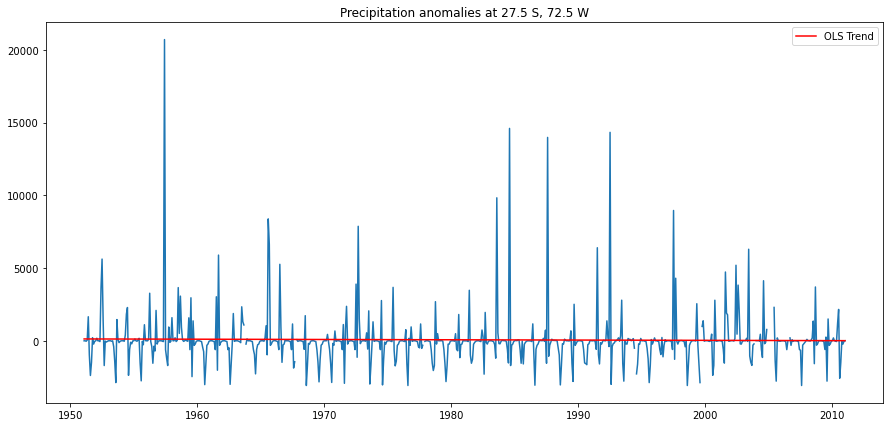

In [41]:
plt.figure(figsize=(15,7))
plt.plot(timeslice,Y)
plt.plot(timeslice, results.predict(X),color='r', label = "OLS Trend")
plt.title("Precipitation anomalies at 27.5 S, 72.5 W")
plt.legend()
plt.show()

We can access the interecept, the slope coefficient (trend) and the $p$ value of the t-test on the statistical significance of the trend:

In [42]:
print(f"Intercept: {results.params[0]:16.3f}")
print(f"Slope coefficient: {results.params[1]:8.3f}")
print(f"p value: {results.pvalues[1]:18.3f}")

Intercept:          125.019
Slope coefficient:   -0.164
p value:              0.622


In this case, the trend is not significantly different from $0$ at the $\alpha = 0.1$ level.

### Trend and p-value for each cell

We now repeat these operations for each grid cell, and store the intercepts, trends and p values in three arrays.

In [43]:
pvs = np.empty([nlat,nlon],dtype=float) # p values
pvs[:,:] = np.nan

trends = np.empty([nlat,nlon],dtype=float) # slopes
trends[:,:] = np.nan

ints = np.empty([nlat,nlon],dtype=float) # intercepts
ints[:,:] = np.nan


for j in tqdm(range(nlon)):
    for i in range(nlat):
        
        # Discard cell data not satisfying the above criteria
        if not validate_pr_data(xgrid, i, j):
            continue
            
        Y = np.array(xgrid.sel(time=slice("1951", "2010"))[:, i, j])
        
        X = np.arange(1, Y.shape[0]+1)
        X = sm.add_constant(X)
        
        # OLS
        # Discard missing values
        nas = np.isnan(Y)
        model = sm.OLS(Y[~nas],X[~nas])
        results = model.fit()
        
        # Store result in array
        pvs[i,j] = results.pvalues[1]
        ints[i,j] = results.params[0]
        trends[i,j] = results.params[1]

Another way to plot the regression line (without having to save the regression model for each cell):

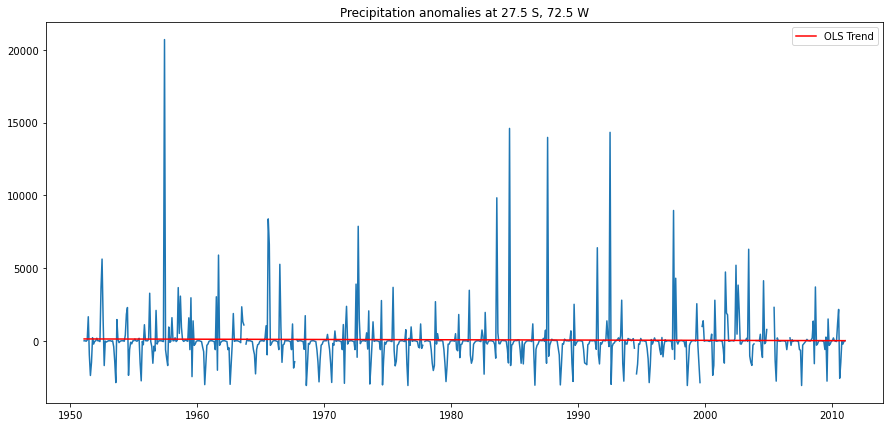

In [44]:
a = ints[23, 21]
b = trends[23, 21]
reg_line = a + b * np.arange(timeslice.shape[0])
Y = np.array(xgrid.sel(time=slice("1951", "2010"))[:, 23, 21])
plt.figure(figsize=(15,7))
plt.plot(timeslice, Y)
plt.plot(timeslice, reg_line, color='r', label="OLS Trend")
plt.legend()
plt.title("Precipitation anomalies at 27.5 S, 72.5 W")
plt.show()

## Plot Precipitation Trends 1951-2010

Level for the rejection of local tests, following Wilks (2016):

In [45]:
alpha_local = 0.1

Locate points where the $p$ value is smaller than the chosen level:

In [46]:
rej_pvs_x, rej_pvs_y = np.where(pvs <= alpha_local) # Warning because some elements of pvs are nans, but it does not matter
rej_pvs_lats = [xlats[i] for i in rej_pvs_x]
rej_pvs_lons = [xlons[i] for i in rej_pvs_y]

/home/gian/anaconda3/envs/dslep/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.


The values in the array of trends are in mm / month. We multiply by 12 to obtain the annual precipitation trends:

In [47]:
yr_trends = trends * 12

Colormap to use for the rest of the notebook:

In [48]:
# Source for make_colormap function : https://www.geeksforgeeks.org/matplotlib-colors-symlognorm-class-in-python/
# Colormap
cmap = make_colormap([to_rgb('black'), to_rgb('saddlebrown'), 0.25, to_rgb('saddlebrown'), to_rgb('linen'), 0.5,
                      to_rgb('aliceblue'), to_rgb('lightskyblue'), 0.75, to_rgb('lightskyblue'), to_rgb('steelblue')])
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = colors.LinearSegmentedColormap.from_list('Custom map', cmaplist, cmap.N)

tick_locations = [-150, -100, -50, -25, -10, -5, -2.5, -0.0, 2.5, 5, 10, 25, 50, 100, 150] # Same as Wilks (2016)
bounds = tick_locations
norm = colors.BoundaryNorm(tick_locations, cmap.N)

We define the grid longitude and latitudes for `pcolormesh`:

In [49]:
grlons =  np.arange(-180, 181, resol, dtype=float)
grlats = -np.arange(-90, 91, resol, dtype=float) # minus in front because data was stored from 90 N to 90 S

Plot of the trends:

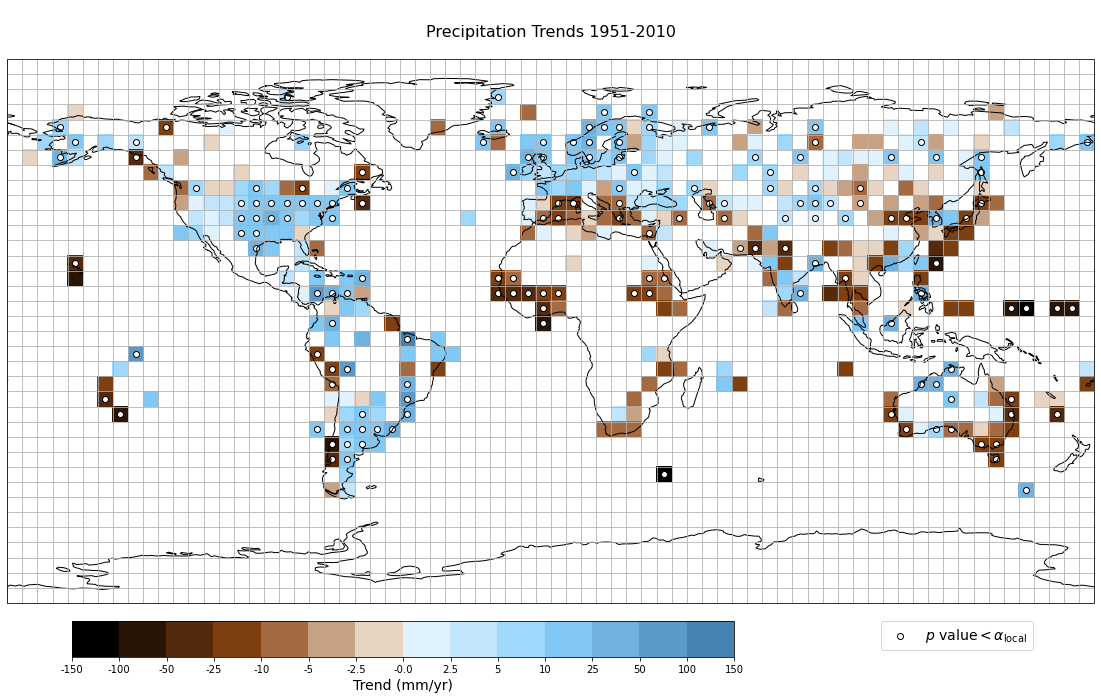

In [50]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines() 
ax.gridlines(xlocs=range(-180,181,resol), ylocs=range(-90,91,resol))

# Title
ax.set_title('\nPrecipitation Trends 1951-2010\n', size=16)

# Pcolormesh
plt.pcolormesh(grlons, grlats, yr_trends, cmap=cmap, norm=norm)

# Scatter
ax.scatter(rej_pvs_lons, rej_pvs_lats, edgecolor='black', facecolor='white',
           label= r"$p$ value$< \alpha_{\mathrm{local}}$") # 'Locally statistically significant test')
plt.legend(loc='lower right', bbox_to_anchor=(0.95,-0.1), prop={"size":14})

# Colorbar

cbar_ax = fig.add_axes([0.18, 0.05, 0.46, 0.05]) #[left, bottom, width, height]
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
                    cax=cbar_ax, orientation='horizontal',
                    ticks = tick_locations)
cbar.ax.set_xticklabels(tick_locations) 
cbar.set_label('Trend (mm/yr)', size=14)

plt.show()

In order to compare these results with those in [Wilks (2016)](https://journals.ametsoc.org/view-large/figure/9553006/bams-d-15-00267_1-f7.tif) we have opted to use a similar colorbar.

### Controlling the False Discovery Rate

We now apply the False Discovery Rate (FDR) approach described in Wilks (2016).

As explained in Wilks (2016), correctly interpreting the results of $N$ multiple simultaneous tests requires a higher standard of evidence than is the case when evaluating results of a single test, especially if these tests are not independent, as is usually the case with gridded data.

(The following is taken from Wilks (2016)).

The FDR is the expected fraction of local null hypothesis test rejections for which the respective null hypotheses are actually true. FDR control addresses the probability that a rejected local null hypothesis is in fact true (whereas a $p$ value quantifies the probability of results at least as inconsistent with the null hypothesis as the observed test statistic, under the assumption that the null hypothesis is true).

The algorithm operates on the collection of $p$ values from $N$ local hypothesis
tests $p_i$, with $i = 1, \ldots, N$, which are first sorted in ascending order.
These sorted $p$ values are denoted using
parenthetical subscripts, so that $p_{(1)} \leq p_{(2)} \leq \ldots \leq
p_{(N)}$. Local null hypotheses are rejected if their respective $p$ values are
no larger than a threshold level $p^*_{\text{FDR}}$ that depends on the
distribution of the sorted $p$ values:
$$p^*_{\text{FDR}} = \max_{i = 1, \ldots, N}\left[p_{(i)}
: p_{(i)}\leq\left(\frac{i}{N}\right)\alpha_{\text{FDR}}\right]$$
where $\alpha_{\text{FDR}}$ is the chosen control level for the FDR.


Let us now implement this approach for the tests that we have just performed on the significance of the trends.

Following Wilks (2016), we use the same control level as the one for the local tests for $\alpha_{\text{FDR}}$.

In [51]:
alpha_FDR = alpha_local
alpha_FDR

0.1

Let us flatten the array with the $p$ values, discarding the missing values.

In [52]:
pvs_flat = pvs[~np.isnan(pvs)].flatten()

We have performed 408 tests (corresponding to the number of cells with data satisfying the above three criteria):

In [53]:
# nas = np.isnan(pvs_flat) # mask to exclude NAs
N = len(pvs_flat)
N

408

Let us sort the $p$ values in ascending order.

In [54]:
pvs_ranked = np.sort(pvs_flat)

We now apply the algorithm and save the $p$ values satisfying the FDR criterion in a new array called `pvs_FDR`.

In [55]:
pvs_FDR = []

for i in range(len(pvs_ranked)):
    current_p = pvs_ranked[i]
    if np.isnan(current_p): # not really necessary
        continue
    if current_p <= ((i+1)/N)*alpha_FDR:
        pvs_FDR.append(current_p)

By definition, $p^*_{\text{FDR}}$ is the maximum of the $p$ values contained in `pvs_FDR`.

In [56]:
p_FDR = np.max(pvs_FDR)
p_FDR

0.02338221162101544

A local null hypothesis in a cell is rejected if the corresponding $p$ values is no larger than $p^*_{\text{FDR}}$.

How many locally rejected tests do not safisfy the FDR criterion?

In [57]:
a = np.sum(pvs_flat <= alpha_local) - np.sum(pvs_flat <= p_FDR)
b = np.sum(pvs_flat <= alpha_local)
print(f"{a}/{b} locally rejected tests do not satisfy the FDR criterion")

60/157 locally rejected tests do not satisfy the FDR criterion


Locate points where the $p$ value is smaller than $p_{\text{FDR}}^*$:

In [58]:
fdr_pvs_x, fdr_pvs_y = np.where(pvs <= p_FDR) # Warning because some elements of pvs are nans, but it does not matter
fdr_pvs_lats = [xlats[i] for i in fdr_pvs_x]
fdr_pvs_lons = [xlons[i] for i in fdr_pvs_y]

/home/gian/anaconda3/envs/dslep/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.


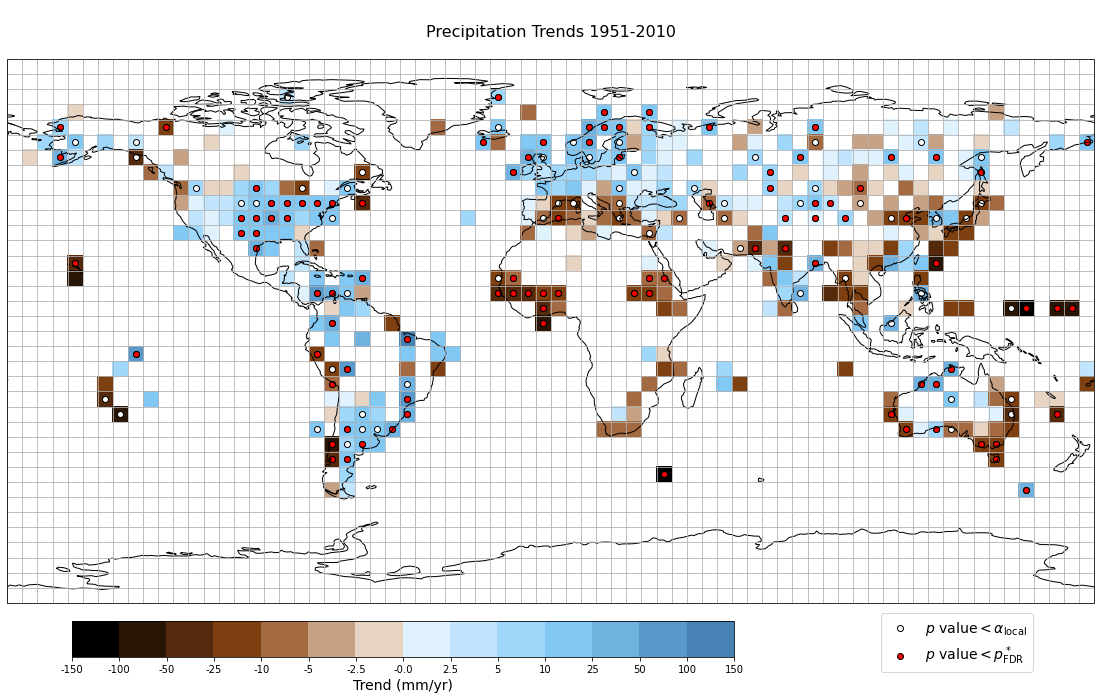

In [59]:
fig = plt.figure(figsize=(20,10))

ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines() 
ax.gridlines(xlocs=range(-180,181,resol), ylocs=range(-90,91,resol))

# Title
ax.set_title('\nPrecipitation Trends 1951-2010\n', size=16)

## Pcolormesh
plt.pcolormesh(grlons, grlats, yr_trends, cmap=cmap, norm=norm)

# Scatter
ax.scatter(rej_pvs_lons, rej_pvs_lats, edgecolor='black', facecolor='white',
           label= r"$p$ value$< \alpha_{\mathrm{local}}$") # 'Locally statistically significant test')
ax.scatter(np.array(fdr_pvs_lons), fdr_pvs_lats, edgecolor="black", facecolor='red',
           label= r"$p$ value$< p^*_{\mathrm{FDR}}$") # '$p$ value satisfies FDR criterion')
plt.legend(loc='lower right', bbox_to_anchor=(0.95,-0.14), prop={"size":14})

# Colorbar
cbar_ax = fig.add_axes([0.18, 0.05, 0.46, 0.05]) #[left, bottom, width, height]
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
                    cax=cbar_ax, orientation='horizontal',
                    ticks = tick_locations)
cbar.ax.set_xticklabels(tick_locations) 
cbar.set_label('Trend (mm/yr)', size=14)

plt.show()

The results obtained here are slightly different from those presented in Wilks (2016). This might be due to the trend estimation method applied in Wilks (2016), which might be more elaborate than a simple OLS Regression linear trend, e.g., one of the methods described in Hartmann et al (2013), which is also referenced in Wilks (2016).

### Interactive plot with map and timeseries (requires ipywidgets)

Let us now include an interactive plot which includes both a map with trends (the same as before) and the precipitation time series for each cell, including the estimated linear trends and $p$ values (where available). One can choose the latitude and longitude of the cell, whether to display the markers regarding the tests, and whether to fix the $y$ axis in order to more easily compare the data from different cells.

In [60]:
import ipywidgets as widgets
import datetime
from matplotlib.offsetbox import AnchoredText

In [61]:
x_trends = xr.DataArray(trends, coords=[xlats, xlons], dims=["lat", "lon"])
yr_x_trends = xr.DataArray(yr_trends, coords=[xlats, xlons], dims=["lat", "lon"])
x_ints = xr.DataArray(ints, coords=[xlats, xlons], dims=["lat", "lon"])
x_pvs = xr.DataArray(pvs, coords=[xlats, xlons], dims=["lat", "lon"])
y_min = np.nanmin(grid/100)
y_max = np.nanmax(grid/100)

def interactive_plot(lat, lon, fixed_yaxis, show_tests):
    
    a = x_ints.sel(lat=lat, lon=lon, method="nearest").values
    b = x_trends.sel(lat=lat, lon=lon, method="nearest").values
    reg_line = a + b * np.arange(timeslice.shape[0])
    
    fig = plt.figure(figsize=(25,8))
    a1 = plt.subplot(121, projection=ccrs.PlateCarree())
    a2 = plt.subplot(122)
    
    ##########
    # Plot 1 #
    ##########
    
    a1.set_global()
    a1.coastlines() 
    a1.gridlines(xlocs=range(-180,181,resol), ylocs=range(-90,91,resol))
    
    # Pcolormash
    a1.pcolormesh(grlons, grlats, yr_trends, cmap=cmap, norm=norm)
    a1.set_title("Precipitation Trends 1951-2010\n", size=14)
    
    # Scatter
    if show_tests:
        a1.scatter(rej_pvs_lons, rej_pvs_lats, edgecolor='black', facecolor='white', alpha=0.6,
                   label= r"$p$ value$< \alpha_{\mathrm{local}}$")
        a1.scatter(np.array(fdr_pvs_lons), fdr_pvs_lats, edgecolor="black", facecolor='red', alpha = 0.6,
                   label= r"$p$ value$< p^*_{\mathrm{FDR}}$")
    
    ##########
    # Plot 2 #
    ##########
    
    Y = xgrid.sel(time=timeslice).sel(lat=lat, lon=lon, method="nearest")/100
    a2.plot(timeslice, Y)
    a2.plot(timeslice, reg_line/100, color='r')
    
    # xlim/ylim
    if fixed_yaxis:
        a2.set_ylim(y_min, y_max)
    a2.set_xlim([datetime.date(1950, 1, 1), datetime.date(2011, 12, 31)])
    
    # Convert, e.g., "-10, 10" to "10 S, 10 E"
    lat_str = f"{np.abs(lat)}"
    lat_str = lat_str+" N" if lat > 0 else lat_str+" S"
    lon_str = f"{np.abs(lon)}"
    lon_str = lon_str+" E" if lat > 0 else lon_str+" W"
    
    # Time series
    
    # If there is no data in a cell:
    if np.all(np.isnan(Y)):
        a2.set_title(f"No Precipitation Data for {lat_str}, {lon_str}", size=14)
    # If the trend is not available (i.e., data was not valid)
    elif np.isnan(b):
        a2.set_title(f"Precipitations Anomalies at {lat_str}, {lon_str} (hundreds)", size=14)
        anchored_text = AnchoredText("Not enough data for 1951-2010 trend estimation",
                                     loc=2,borderpad=0.,frameon=False, prop=dict(size=12))
        a2.add_artist(anchored_text)
    # Otherwise
    else:
        a2.set_title(f"Precipitations Anomalies at {lat_str}, {lon_str} (hundreds)", size=14)
        p = x_pvs.sel(lat=lat, lon=lon).values
        if p < 1e-3:
            p_str = f"$p$ value: {p:4.3e}\n"
        else:
            p_str = f"$p$ value: {p:4.4f}\n"
        anchored_text = AnchoredText(p_str +
            f"Trend: {yr_x_trends.sel(lat=lat, lon=lon).values:4.2f} mm / year",
            loc=2, borderpad=0.0, frameon=False, prop=dict(size=12))
        
        a2.add_artist(anchored_text)
    
    
    a2.yaxis.set_label_position("right")
    a2.yaxis.tick_right()
    
    # Moving Marker
    a1.plot(lon, lat, marker = "s", color="magenta", markersize=8, fillstyle="full", label="Current position", lw=0)
    if show_tests:
        a1.legend(loc='lower right', bbox_to_anchor=(0.95,-0.25), prop={"size":11})
    else:
        a1.legend(loc='lower right', bbox_to_anchor=(0.95,-0.125), prop={"size":11})
    
    fig.tight_layout()
    
    ############
    # Colorbar #
    ############
    
    cbar_ax = fig.add_axes([0.235, 0.25, 0.25, 0.05]) #[left, bottom, width, height]
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),
                        cax=cbar_ax, orientation='horizontal',
                        ticks = tick_locations)
    cbar.ax.set_xticklabels(tick_locations) 
    cbar.set_label('Trend (mm/yr)', size=14)

    plt.show()
    

In [62]:
lat_slider = widgets.FloatSlider(min=-87.5, max=87.5, value=-27.5, step = 5,
                                description="Latitude")
lon_slider = widgets.FloatSlider(min=-177.5, max=177.5, value=-72.5, step = 5,
                                description="Longitude")
fix_y_checkbox =   widgets.Checkbox(value=False, description='Fix y axis')
tests_checkbox =   widgets.Checkbox(value=False, description='Show tests')

out = widgets.interactive_output(interactive_plot, {"lat" : lat_slider, "lon" : lon_slider,
                                              "fixed_yaxis":fix_y_checkbox,
                                              "show_tests":tests_checkbox})
out.layout.height = '500px'
ui = widgets.HBox([lat_slider, lon_slider, tests_checkbox, fix_y_checkbox])

display(ui, out)

Output(layout=Layout(height='500px'))